# GWP 1 Submission 1: Price a European Up-and-out Call Option 

*(References: MScFE 630 CF_Compiled_Notes_M2, MScFE 630 CF_Compiled_Notes_M3)*

Use the following parameters:
* Option maturity is one year 
* The option is struck at-the-money
* The up-and-out barrier for the option is *150*
* The current share price is *100*
* The risk-free continuously compounded interest rate is 8%
* The volatility for the underlying share is 30%
* The volatility for the counterparty’s firm value is 25%
* The counterparty’s debt, due in one year, is *175*
* The correlation between the counterparty and the stock is constant at 0.2
* The recovery rate with the counterparty is 25%.

__1. What are the advantages and disadvantages of purchasing the up-and-out barrier call 
option, compared to the plain vanilla European call option?__

*Advantages:*

*  An up-and-out option tends to be cheaper than similar vanilla calls, thus a typical European call is tend to be more expensive than a UAO European call. For instance, portfolio managers are using these UAO options because they are typically less expensive hedging methods against losses on a short position. These sorts of hedge strategies can be less expensive than buying plain vanilla call options. 

* The Up-and-out option are OTC instruments, so they can be customized.

*Disadvantages:*

* it will be imperfect as the buyer will be unprotected if the stock price rises above the barrier price. In case of a large move can result a huge loss for the hedger.

* As Up-and-out options are OTC instruments, they are not as liquid nor transparent as exchange listed options.

* These are not available for retail traders.

__2. Would you expect to find this option on an exchange, or Over-The-Counter?__

These type of excotic options are OTC instruments, so we expect to find these Over-The-Counter.

__3. Is there a closed-form, analytical solution for pricing an up-and-out barrier call option?__

Yes there is, first Heynes and Kat derived this solution from the Black-Scholes formula and they expressed it as bivariate normal distribution funcion. In order the get the closed-form solution, the heat equation has to be reduced from the Black-Scholes PDE.

* Importing libraries

In [1]:
import numpy as np
import pandas as pd
import math
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import log,exp,sqrt,stats
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

* Parameters:

In [2]:
#Parameters:
risk_free_rate = 0.08
#Share specific information
S_0 = 100 #current share price
sigma = 0.3 #Volatility
#Option specific information
K = S_0    #Strike as it`s at-the-money option
B = 150   #up-and-out barrier
T = 1 #Maturity
current_time = 0.08
#Firm specific information
V_0 = 200 #Initial firm value
sigma_firm = 0.2 #Firm value volatility
debt = 175       #Debt of the firm
recovery_rate = 0.25
corr = 0.2    #Correlation between the counterparty and the stock price
dT = 1/12 #monthly simulations
corr_matrix = np.array([[1, corr], [corr, 1]]) #Correlation Matrix
L = np.linalg.cholesky(corr_matrix) #Cholesky decomposition

__4. Price a European call option with the information provided.__

In [3]:
d1 = (math.log(S_0/K)+(risk_free_rate+sigma**2/2)*(T-current_time))/(sigma*math.sqrt(T-current_time))
d2 = d1-sigma*math.sqrt(T-current_time)
european_call = S_0*norm.cdf(d1)-K*math.exp(-risk_free_rate*(T-current_time))*norm.cdf(d2)
print("Price of a European call option: {:.2f}".format(european_call))

Price of a European call option: 14.94


__5. Price a European up-and-out barrier call option: Simulate paths for the underlying share and 
for the counterparty’s firm value using sample sizes of 1000, 2000, …, 50000. Do monthly 
simulations for the lifetime of the option.__

* First let`s import our terminal share price function from the previous module:

We are going to be using this function to model for both our stock and our firm values.

In [4]:
#Terminal share function.
def terminal_value(S_0, risk_free_rate,sigma,Z,T):
    """Generates the terminal share price given some random normal values, Z"""
    return S_0*np.exp((risk_free_rate-sigma**2/2)*T+sigma*np.sqrt(T)*Z)

* The code below is used to generate our underlying share and the counterparty’s firm value path.

In [5]:
def share_path(S_0, risk_free_rate, sigma, Z, dT):
    """Generate the price path given intial price and some random normal values, Z"""
    return S_0 * np.exp(np.cumsum((risk_free_rate - sigma**2/2)*dT + sigma*np.sqrt(dT)*Z, axis=0))

* Function calculates the payoff of up-and-out call option given a share price path.

In [6]:
def upout_call_payoff(path, K, risk_free_rate, T):
    """Calculating the payoff of up-and-out call option given a share price path."""
    if path.any() > B:
        return 0
    else:
        return np.maximum(path[-1] - K,0)

* Empty arrays for the share, firm and the up and out option price, in order to store the estimated values for different sample sizes:

In [7]:
np.random.seed(0)
mc_share_price = [None]*50
mc_firm_value = [None]*50
mc_upout_price100 = [None]*50

* Finally, Generating Monte Carlo estimates for share price and firm value, looping through the sample sizes:

In [8]:
for i in range(1, 51):
    norm_martix = norm.rvs(size=[12, 2, i*1000])
    corr_norm_martix = np.array([np.matmul(L, x) for x in norm_martix]) 
#Simulated share price paths:
    mc_price_path = np.array([share_path(S_0, risk_free_rate, sigma, Z_share, dT) for Z_share in corr_norm_martix[:,0,:].T])
#Simulated firm value paths:
    mc_firm_value = np.array([share_path(V_0, risk_free_rate, sigma_firm, Z_firm, dT) for Z_firm in corr_norm_martix[:,1,:].T])
   
    mc_upout_payoff100 = np.array([upout_call_payoff(path, K, risk_free_rate, T) for path in mc_price_path])

#Calculation of default-free value of the option per 1000 sample size
    mc_upout_price100[i-1] = np.mean(mc_upout_payoff100)
#Final share price and firm value
    mc_share_price[i-1] = np.mean(mc_price_path[:, -1])
    mc_firm_value[i-1] = np.mean(mc_firm_value[:, -1])

* For illustration, below, we plot the Monte Carlo estimates for Share price paths for sample size of 1000, also showing the Barrier level at 150:

In [9]:
mc_price_path_pd = pd.DataFrame(mc_price_path) #Converting array to DataFrame

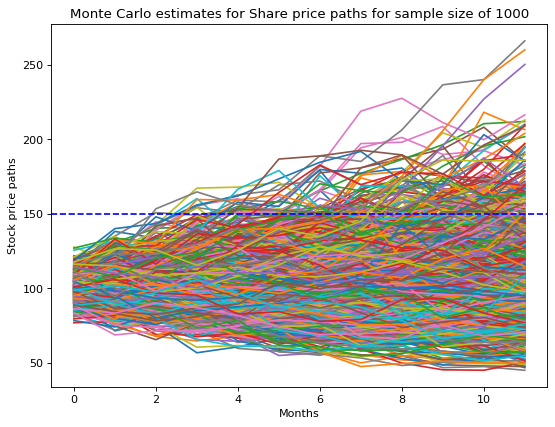

In [10]:
figure(figsize=(8, 6), dpi=80)
plt.plot(mc_price_path_pd[0:1000].T)
plt.title("Monte Carlo estimates for Share price paths for sample size of 1000")
plt.ylabel('Stock price paths',fontsize=10)
plt.xlabel('Months',fontsize=10)
plt.axhline(y = B, color = 'blue', linestyle = 'dashed') #This indicate the barrier level at $150
plt.show()

* For illustration, below, we plot the Monte Carlo estimates for Firm values for sample size of 1000:

In [11]:
mc_firm_value_pd = pd.DataFrame(mc_firm_value) #Converting array to DataFrame

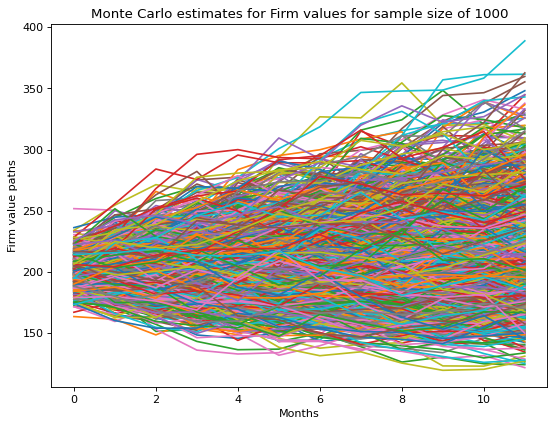

In [12]:
figure(figsize=(8, 6), dpi=80)
plt.plot(mc_firm_value_pd[0:1000].T)
plt.title("Monte Carlo estimates for Firm values for sample size of 1000")
plt.ylabel('Firm value paths',fontsize=10)
plt.xlabel('Months',fontsize=10)
plt.show()

__6. Price a European up-and-in barrier call option. Hint: Use the 2 other option prices.__

* As per the definition the buyer of the option will benefit once the price of the underlying rises high enough to reach (knock in) the designated barrier price level. Otherwise the option will expire worthless. Thus an up-and-in option comes into existence only if the underlying reaches a barrier price that is above the current underlying's price.


* Once the up-and-out option values are known, their up-and-in counterparts are valued by out-in parity
with the corresponding vanilla option. At maturity, exactly one of the two will pay off identically to the
corresponding vanilla option, which of the two that depends on whether the knock-in/out event has
occurred before maturity.


* The up-and-out option acts like any other option, and pays out the same as a plain vanilla call, assume that there are no rebates until the underlying stock increases above the barrier price level.


As per our parameters at T = 0, the option is struck at-the-money so S_0 = K (100), and we already priced a European call option with the given parameters, and the price is 14.94, because the stock price is below the barrier level of 150, the up-and-out call option is acting like our European call option.

So, we can use the out-in parity formula to find the price of the up-and-in call option:
                                        
                                        C = C_in + C_out

In [13]:
C_in = 14.94 - 14.94 #out-in parity formula
C_in

0.0

After we solve the equation, we can see that the price of the European up-and-in barrier call option is 0.

* We also can use the code found the in the Exotic Options in Python - Examples.ipynb file, and just switch the > sign to <.

In [14]:
def bs_call(S_0,K,T,risk_free_rate,sigma):
    """
       Returns: Call value under Black-Schole-Merton option model
       Format   : bs_call(S,X,T,r,sigma)
               S: current stock price
               X: exercise price
               T: maturity date in years
              rf: risk-free rate (continusouly compounded)
           sigma: volatiity of underlying security 
    """    
    from scipy import log,exp,sqrt,stats
    d1=(log(S_0/K)+(risk_free_rate+sigma*sigma/2.)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    return S_0*stats.norm.cdf(d1)-K*exp(-risk_free_rate*T)*stats.norm.cdf(d2)

In [15]:
n_simulation = 100 #Number of simulations

def up_and_in_call(S_0,K,T,risk_free_rate,sigma,n_simulation,B):
    """
        Returns: Call value of an up-and-out barrier option with European call
    """
    n_steps= 100 #Define number of steps.
    dt = T/n_steps
    total=0
    for j in range(0,n_simulation):
        sT=S_0
        out=False
        for i in range(0,int(n_steps)):
            e= sp.random.normal()
            sT*=sp.exp((risk_free_rate-T*sigma**2)*dt+sigma*e*sp.sqrt(dt))
            if sT<B:
                out=True
        
        if out==False:
            total+=bs_call(S_0,K,T,risk_free_rate,sigma)
    return total/n_simulation

In [16]:
up_and_in_call(S_0,K,T,risk_free_rate,sigma,n_simulation,B)

0.0

* As we can see, after running the code we also get 0.

__7. Repeat Question 5 (Price up-and-out barrier call) 6 times, keeping all the data the same, but 
using a new strike level in each case:__ 
* a) 85, b) 90, c) 95, d) 105, e) 110, f) 115. 

__Produce a table of 7 rows that shows the strike, and the option price.__

* Empty arrays for the  up and out option price, in order to store the estimated values for different sample sizes:

In [17]:
mc_upout_price85 = [None]*50
mc_upout_price90 = [None]*50
mc_upout_price95 = [None]*50
mc_upout_price105 = [None]*50
mc_upout_price110 = [None]*50
mc_upout_price115 = [None]*50

In [18]:
for i in range(1, 51):
    K_85 = 85 #Strike level @ 85
    norm_martix = norm.rvs(size=[12, 2, i*1000])
    corr_norm_martix = np.array([np.matmul(L, x) for x in norm_martix]) 
    mc_price_path = np.array([share_path(S_0, risk_free_rate, sigma, Z_share, dT) for Z_share in corr_norm_martix[:,0,:].T])
    mc_upout_payoff85 = np.array([upout_call_payoff(path, K_85, risk_free_rate, T) for path in mc_price_path])
#Final call option price
    mc_upout_price85[i-1] = np.mean(mc_upout_payoff85)
    K_90 = 90 #Strike level @ 90
    mc_upout_payoff90 = np.array([upout_call_payoff(path, K_90, risk_free_rate, T) for path in mc_price_path])
#Final call option price
    mc_upout_price90[i-1] = np.mean(mc_upout_payoff90)
    K_95 = 95 #Strike level @ 95
    mc_upout_payoff95 = np.array([upout_call_payoff(path, K_95, risk_free_rate, T) for path in mc_price_path])
#Final call option price
    mc_upout_price95[i-1] = np.mean(mc_upout_payoff95)
    K_105 = 105 #Strike level @ 105
    mc_upout_payoff105 = np.array([upout_call_payoff(path, K_105, risk_free_rate, T) for path in mc_price_path])
#Final call option price
    mc_upout_price105[i-1] = np.mean(mc_upout_payoff105)
    K_110 = 110 #Strike level @ 110
    mc_upout_payoff110 = np.array([upout_call_payoff(path, K_110, risk_free_rate, T) for path in mc_price_path])
#Final call option price
    mc_upout_price110[i-1] = np.mean(mc_upout_payoff110)
    K_115 = 115 #Strike level @ 115
    mc_upout_payoff115 = np.array([upout_call_payoff(path, K_115, risk_free_rate, T) for path in mc_price_path])
#Final call option price
    mc_upout_price115[i-1] = np.mean(mc_upout_payoff115)

In [19]:
print("Final call option price with Strike 85:", mc_upout_price85[i-1])
print("Final call option price with Strike 90:", mc_upout_price90[i-1])
print("Final call option price with Strike 95:", mc_upout_price95[i-1])
print("Final call option price with Strike 105:", mc_upout_price105[i-1])
print("Final call option price with Strike 110:", mc_upout_price110[i-1])
print("Final call option price with Strike 115:", mc_upout_price115[i-1])

Final call option price with Strike 85: 26.547431692492815
Final call option price with Strike 90: 22.997506918299162
Final call option price with Strike 95: 19.77330480097876
Final call option price with Strike 105: 14.326564232666788
Final call option price with Strike 110: 12.089704473786915
Final call option price with Strike 115: 10.153120221552815


* A table of 7 rows that shows the strike, and the option price:

In [20]:
final_call_option_price = [mc_upout_price85[i-1], mc_upout_price90[i-1], 
                           mc_upout_price95[i-1],mc_upout_price100[i-1], mc_upout_price105[i-1], mc_upout_price110[i-1], mc_upout_price115[i-1]]

final_table = pd.DataFrame(final_call_option_price, index =['K = 85','K = 90','K = 95', 'K = 100', 'K = 105', 'K = 110','K = 115'], 
                  columns = ['Final Option Price'],)
final_table

,Final Option Price
K = 85,26.547432
K = 90,22.997507
K = 95,19.773305
K = 100,16.941891
K = 105,14.326564
K = 110,12.089704
K = 115,10.153120


__8. Determine Monte Carlo estimates of both the default-free value of the option and the 
Credit Valuation Adjustment (CVA). You can take an initial firm value like of $200 for your 
calculations.__


In order to make an estimation, we rather calculate the average payoff per sample size of 1000.

* Empty arrays for the up and out option price and CVA estimates in order to store the estimated values for different sample sizes:

In [21]:
np.random.seed(0)
mc_upout_price = [None]*50
mc_cva_estimates = [None]*50
mc_cva_std = [None]*50
mc_option_std = [None]*50

* Generating Monte Carlo estimates for the default-free value of the option, looping through the sample sizes:

In [22]:
for i in range(1, 51):
    norm_martix = norm.rvs(size=[12, 2, i*1000])
#correlated random numbers for share price and firm value
    corr_norm_martix = np.array([np.matmul(L, x) for x in norm_martix]) 
    mc_price_path = np.array([share_path(S_0, risk_free_rate, sigma, Z_share, dT) for Z_share in corr_norm_martix[:,0,:].T])
    mc_upout_payoff = np.array([upout_call_payoff(path, K, risk_free_rate, T) for path in mc_price_path])
    # risk amount due to default risk, on each sample path
    amount_lost = np.array([np.exp(-risk_free_rate*T)*(1-recovery_rate)*(term_firm_val < debt)*call_val 
                            for term_firm_val, call_val in zip(mc_firm_value[:,-1], mc_upout_payoff)])
#Calculation of default-free value of the option per 1000 sample size
    mc_upout_price[i-1] = np.mean(mc_upout_payoff)
    mc_option_std[i-1]= np.std(mc_upout_payoff)/np.sqrt(i*1000)
#Calulation of average CVA estimates per 1000 sample size
    mc_cva_estimates[i-1] = np.mean(amount_lost)
    mc_cva_std[i-1]= np.std(amount_lost)/np.sqrt(i*1000)

* Below, we print out the default-free value of the option at the Sample Sizes:

In [23]:
for i in range(len(mc_upout_price100)):
    print("Sample of {}: The default-free value of the option: {:.2f}".format((i+1)*1000,mc_upout_price[i]))

Sample of 1000: The default-free value of the option: 16.43
Sample of 2000: The default-free value of the option: 16.58
Sample of 3000: The default-free value of the option: 17.66
Sample of 4000: The default-free value of the option: 16.90
Sample of 5000: The default-free value of the option: 16.50
Sample of 6000: The default-free value of the option: 17.65
Sample of 7000: The default-free value of the option: 17.38
Sample of 8000: The default-free value of the option: 16.87
Sample of 9000: The default-free value of the option: 16.67
Sample of 10000: The default-free value of the option: 16.79
Sample of 11000: The default-free value of the option: 17.25
Sample of 12000: The default-free value of the option: 16.91
Sample of 13000: The default-free value of the option: 16.87
Sample of 14000: The default-free value of the option: 16.63
Sample of 15000: The default-free value of the option: 17.00
Sample of 16000: The default-free value of the option: 17.07
Sample of 17000: The default-free

* Below, we plot the Monte Carlo estimates versus the samle size:

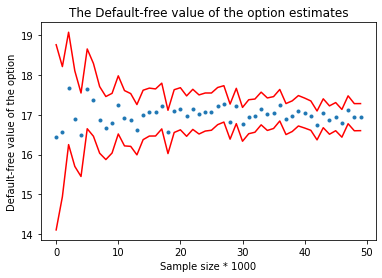

In [24]:
plt.plot(mc_upout_price, '.')
plt.plot(mc_upout_price + 3 * np.array(mc_option_std), 'r')
plt.plot(mc_upout_price - 3 * np.array(mc_option_std), 'r')
plt.title("The Default-free value of the option estimates")
plt.xlabel("Sample size * 1000")
plt.ylabel("Default-free value of the option")
plt.show()

* Below, we print out the Credit Valuation Adjustments (CVA) estimates at the Sample Sizes:

In [25]:
for i in range(len(mc_cva_estimates)):
    print("Sample of {}: CVA estimates: {:.2f}".format((i+1)*1000,mc_cva_estimates[i]))

Sample of 1000: CVA estimates: 1.99
Sample of 2000: CVA estimates: 1.90
Sample of 3000: CVA estimates: 1.91
Sample of 4000: CVA estimates: 1.94
Sample of 5000: CVA estimates: 2.02
Sample of 6000: CVA estimates: 2.04
Sample of 7000: CVA estimates: 2.13
Sample of 8000: CVA estimates: 2.10
Sample of 9000: CVA estimates: 2.00
Sample of 10000: CVA estimates: 2.00
Sample of 11000: CVA estimates: 2.00
Sample of 12000: CVA estimates: 2.04
Sample of 13000: CVA estimates: 2.17
Sample of 14000: CVA estimates: 2.03
Sample of 15000: CVA estimates: 2.01
Sample of 16000: CVA estimates: 1.97
Sample of 17000: CVA estimates: 1.97
Sample of 18000: CVA estimates: 2.07
Sample of 19000: CVA estimates: 1.95
Sample of 20000: CVA estimates: 2.00
Sample of 21000: CVA estimates: 2.01
Sample of 22000: CVA estimates: 1.99
Sample of 23000: CVA estimates: 2.05
Sample of 24000: CVA estimates: 2.06
Sample of 25000: CVA estimates: 2.05
Sample of 26000: CVA estimates: 2.04
Sample of 27000: CVA estimates: 2.09
Sample of 

* Finally, we plot our Monte Carlo CVA estimates versus the samle size:

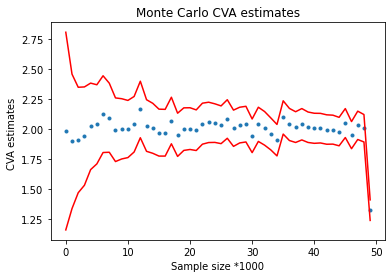

In [26]:
plt.plot(mc_cva_estimates, '.')
plt.plot(mc_cva_estimates + 3 * np.array(mc_cva_std), 'r')
plt.plot(mc_cva_estimates - 3 * np.array(mc_cva_std), 'r')
plt.title("Monte Carlo CVA estimates")
plt.xlabel("Sample size *1000")
plt.ylabel("CVA estimates ")
plt.show()

__9. Calculate the Monte Carlo estimates for the price of the option incorporating counterparty 
risk, given by the default-free price less the CVA.__

In [27]:
risk_call_price = [None]*50

for i in range(1, 51):
    risk_call_price[i-1] = mc_upout_price[i-1] - mc_cva_estimates[i-1]

* Below, we print out the CVA-adjusted option values at the Sample Sizes:

In [28]:
for i in range(len(risk_call_price)):
    print("Sample of: {}, CVA-adjusted option value: {:.2f}".format((i+1)*1000,risk_call_price[i]))

Sample of: 1000, CVA-adjusted option value: 14.45
Sample of: 2000, CVA-adjusted option value: 14.68
Sample of: 3000, CVA-adjusted option value: 15.75
Sample of: 4000, CVA-adjusted option value: 14.96
Sample of: 5000, CVA-adjusted option value: 14.48
Sample of: 6000, CVA-adjusted option value: 15.61
Sample of: 7000, CVA-adjusted option value: 15.25
Sample of: 8000, CVA-adjusted option value: 14.78
Sample of: 9000, CVA-adjusted option value: 14.67
Sample of: 10000, CVA-adjusted option value: 14.79
Sample of: 11000, CVA-adjusted option value: 15.25
Sample of: 12000, CVA-adjusted option value: 14.87
Sample of: 13000, CVA-adjusted option value: 14.70
Sample of: 14000, CVA-adjusted option value: 14.59
Sample of: 15000, CVA-adjusted option value: 14.99
Sample of: 16000, CVA-adjusted option value: 15.10
Sample of: 17000, CVA-adjusted option value: 15.09
Sample of: 18000, CVA-adjusted option value: 15.15
Sample of: 19000, CVA-adjusted option value: 14.62
Sample of: 20000, CVA-adjusted option va